### Requirements
put these files in the same directory
- input.nn
- scaling.data
- weights.xxx.data

In [9]:
import sys
sys.path.append(["/home/ueda/n2p2-work", "/home/ueda/n2p2/src/pynnp"])
from generate_n2p2_input_old import get_dft_force
import matplotlib.pyplot as plt
import pynnp
import os
# you can change directory path of state output
directory = '/home/yyamada/database/data'

In [28]:
paths = [os.path.join(root,file) for root, dirs, files in os.walk(directory) for file in files]
# only include filename `nfout`
state_out_paths = [p for p in paths if 'nfout' in p]
print(state_out_paths)
results = []

# write n2p2 input file
for idx, path in enumerate(state_out_paths):
    structure, energy, forces = get_dft_force(path)
    with open(f'input.data.{idx}', 'w') as f:     
        print('begin', file=f)
        for cell in structure.cell:
            print('lattice', *cell, file=f)
        for i, j in enumerate(structure):
            print('atom', *j.position, j.symbol,'0.0','0.0',*forces[i], file=f)
        print('energy', energy, file=f)
        print('end', file=f)     
    # Initialize NNP prediction mode.
    p = pynnp.Prediction()

    # Read settings and setup NNP.
    p.setup()

    # Read in structure.
    p.readStructureFromFile(f'input.data.{idx}')

    # Predict energies and forces.
    p.predict()

    # Shortcut for structure container.
    s = p.structure
    results.append(s)

['/home/yyamada/database/data/nfout_1_1.5', '/home/yyamada/database/data/nfout_1_2', '/home/yyamada/database/data/nfout_1_1', '/home/yyamada/database/data/nfout_1_2.5', '/home/yyamada/database/data/nfout_1_3', '/home/yyamada/database/data/nfout_1_3.5', '/home/yyamada/database/data/nfout_1_4', '/home/yyamada/database/data/nfout_1_5', '/home/yyamada/database/data/nfout_1_4.5', '/home/yyamada/database/data/nfout_2_5']

*******************************************************************************

WELCOME TO n²p², A SOFTWARE PACKAGE FOR NEURAL NETWORK POTENTIALS!
------------------------------------------------------------------

n²p² version  (from git): v2.1.4-10-gad8e1ea
             (version.h): v2.1.4
------------------------------------------------------------
Git branch              : master
Git revision            : ad8e1ea908487ede0fa65110b1be6364ddb9b228
Compile date/time       : Feb  2 2022 23:18:34
------------------------------------------------------------

Features/Flags:


In [35]:
import pandas as pd
import numpy as np

In [62]:
forces = np.array([[i+1, j+1] + c.r.r+ c.f.r + c.fRef.r for i, r in enumerate(results) for j, c in enumerate(r.atoms)])

[[-58536.54559382 -58552.38704214]
 [-58536.49949091 -58552.12400681]
 [-58536.63197253 -58552.46994271]
 [-58536.58615913 -58551.94007118]
 [-58536.67711351 -58551.81697775]
 [-58536.72954784 -58551.72976607]
 [-58536.7319414  -58551.69142632]
 [-58536.85681038 -58551.72683432]
 [-58536.78753692 -58551.70660891]
 [-58536.85681038 -58551.72683704]]


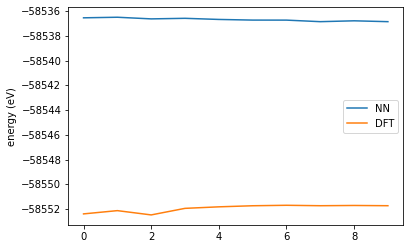

In [108]:
# enegry of process
energy = np.array([[r.energy, r.energyRef] for r in results])
print(energy)
# plot force component 
fig = plt.figure()
plt.plot(energy, label=['NN', 'DFT'])
plt.ylabel('energy (eV)')
plt.legend()

In [64]:
df = pd.DataFrame(forces)
df.columns = ['structure_index', 'atom_index', 'x','y','z', 'fx', 'fy','fz','fxRef','fyRef','fzRef']

In [79]:
df['fxDiff'] = abs(df['fx'] - df['fxRef'])
df['fyDiff'] = abs(df['fy'] - df['fyRef'])
df['fzDiff'] = abs(df['fz'] - df['fzRef'])

In [80]:
nn_force_component = pd.concat([df['fx'],df['fy'], df['fz']]) 
dft_force_component = pd.concat([df['fxRef'],df['fyRef'], df['fzRef']])
diff_force_component = pd.concat([df['fxDiff'],df['fyDiff'], df['fzDiff']])

In [81]:
concat_force_component = pd.concat([nn_force_component,dft_force_component, diff_force_component], axis=1)
concat_force_component.columns = ['nn_force', 'dft_force','diff']

In [82]:
concat_force_component['nn_force'] *= 1000
concat_force_component['dft_force'] *= 1000
concat_force_component['diff'] *= 1000
mae = abs(concat_force_component['diff']).sum() / len(concat_force_component)

In [83]:
print(mae)

161.01948528853995


In [92]:
nn_max = max(concat_force_component['nn_force'])
dft_max = max(concat_force_component['dft_force'])
f_max = round(max([a,b]))

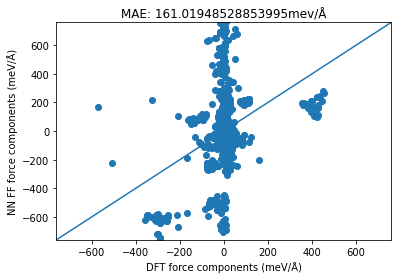

In [94]:
# plot force component 
fig = plt.figure()
plt.plot(np.linspace(-f_max,f_max), np.linspace(-f_max,f_max))
plt.scatter(concat_force_component['dft_force'],concat_force_component['nn_force'])
plt.title(f'MAE: {mae}mev/Å')
plt.xlim(-f_max,f_max)
plt.ylim(-f_max,f_max)
plt.xlabel('DFT force components (meV/Å)')
plt.ylabel('NN FF force components (meV/Å)')